**IMPORTING LIBRARIES**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

**IMPORTING NECESSARY FILES FOR TRAINING(MAN/WOMEN)**

In [ ]:
img_dims = (96,96,3)
data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'/content/drive/MyDrive/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # /content/drive/MyDrive/gender_dataset_face/woman/face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

**PREPROCESSING**

In [ ]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

# augmenting datset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

**BUILD AND COMPILE THE MODEL**

In [ ]:
# initial training parameters
epochs = 50
lr = 1e-3
batch_size = 64

# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

**TRAINING MODEL**

In [ ]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

Epoch 1/50
28/28 [==============================] - 7s 189ms/step - loss: 0.9092 - accuracy: 0.6990 - val_loss: 0.6947 - val_accuracy: 0.4848
Epoch 2/50
28/28 [==============================] - 4s 153ms/step - loss: 0.5254 - accuracy: 0.7923 - val_loss: 0.7885 - val_accuracy: 0.5152
Epoch 3/50
28/28 [==============================] - 4s 154ms/step - loss: 0.4156 - accuracy: 0.8254 - val_loss: 1.0683 - val_accuracy: 0.5152
Epoch 4/50
28/28 [==============================] - 4s 153ms/step - loss: 0.3414 - accuracy: 0.8681 - val_loss: 0.9976 - val_accuracy: 0.5152
Epoch 5/50
28/28 [==============================] - 4s 153ms/step - loss: 0.3582 - accuracy: 0.8697 - val_loss: 1.0061 - val_accuracy: 0.5281
Epoch 6/50
28/28 [==============================] - 4s 154ms/step - loss: 0.3348 - accuracy: 0.8709 - val_loss: 1.2502 - val_accuracy: 0.5195
Epoch 7/50
28/28 [==============================] - 4s 156ms/step - loss: 0.3154 - accuracy: 0.8855 - val_loss: 1.0445 - val_accuracy: 0.5130
Epoch 

**SAVE THE MODEL**

In [ ]:
# save the model to disk
model.save('/content/drive/MyDrive/gender_detection.model')

**PLOT MODEL**

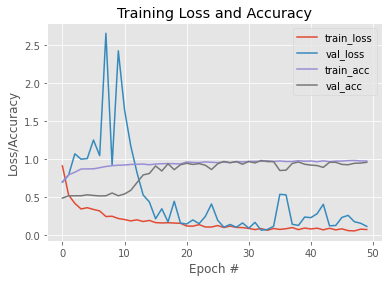

In [ ]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

**TEST PREDICTION**

In [ ]:
!pip install cvlib

In [ ]:
import cvlib as cv
input_image = cv2.imread('/content/cr7.png')
face, confidence = cv.detect_face(input_image)
labels = ["Man","Woman"]

In [ ]:
start_X, start_Y, end_X, end_Y = face[0]

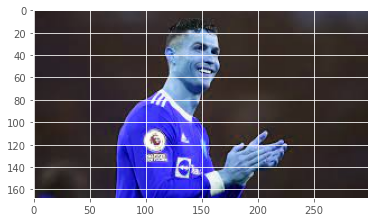

In [ ]:
plt.imshow(input_image)

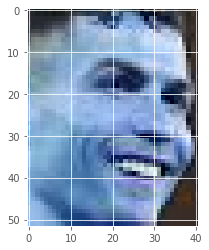

In [ ]:
plt.imshow(input_image[start_Y:end_Y,start_X:end_X])

In [ ]:
resize_image = cv2.resize(input_image[start_Y:end_Y,start_X:end_X],(96,96))

In [ ]:
resize_image = resize_image.astype("float")/ 255.0
img_array = img_to_array(resize_image)
final_image = np.expand_dims(img_array, axis=0)

In [ ]:
prediction = model.predict(final_image)[0]

In [ ]:
Predicted_label = labels[np.argmax(prediction)]

In [ ]:
Predicted_label

'Man'